In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

### 1. 

A news vendor sells newspapers and tries to maximize
profits. The number of papers sold each day is a random
variable. However, analysis of the past month’s data shows
the distribution of daily demand in the table below. A paper costs
the vendor 20¢. The vendor sells the paper for 30¢. Any
unsold papers are returned to the publisher for a credit of
10¢. Any unsatisfied demand is estimated to cost 10¢ in
goodwill and lost profit. If the policy is to order a quantity
equal to the preceding day’s demand, determine the average
daily profit of the news vendor by simulating this system.
Assume that the demand for day 0 is equal to 32.

Demand per Day|Probability
:-:|:-:
30|.05
31|.15
32|.22
33|.38
34|.14
35|.06

In [10]:
def generate_demand(demand_dict):

    r, c = np.random.random(), 0

    for d, p in demand_dict.items():
        c += p
        if c >= r:
            return d
        
demand_per_day = {
    30: 0.05,
    31: 0.15,
    32: 0.22,
    33: 0.38,
    34: 0.14,
    35: 0.06
}


sim = pd.DataFrame({
    "demand": [generate_demand(demand_per_day) for _ in range(10_000)]
})


sim["policy"] = sim["demand"].shift().fillna(32).astype(int)

sim["profit"] = sim.apply(
    lambda r: r["policy"] * 0.3 - (r["demand"] - r["policy"])*0.1 - r["policy"] * 0.2 if r["policy"] < r["demand"] \
        else r["demand"] * 0.3 + (r["policy"] - r["demand"])*0.1 - r["policy"] * 0.2 if r["policy"] > r["demand"] \
            else r["demand"] * 0.3 - r["demand"] * 0.2, \
                axis=1
)

print(f"${sim['profit'].mean():,.2f}")

$3.05


### 2.

An airport hotel has 100 rooms. On any given night, it
takes up to 105 reservations, because of the possibility of
no-shows. Past records indicate that the number of daily
reservations is uniformly distributed over the integer range
[96, 105]. That is, each integer number in this range has an
equal probability, .1, of showing up. The no-shows are
represented by the distribution in the table below. Develop a
simulation model to find the following measures of
performance of this booking system: the expected number
of rooms used per night and the percentage of nights when
more than 100 rooms are claimed.

Number of No-Shows|Probability|||Number of Reservations|Probability
:-:|:-:|:-:|:-:|:-:|:-:
0|0.10|||96|0.1
1|0.20|||97|0.1
2|0.25|||98|0.1
3|0.30|||99|0.1
4|0.10|||100|0.1
5|0.05|||101|0.1
$\text{ }$||||102|0.1
$\text{ }$||||103|0.1
$\text{ }$||||104|0.1
$\text{ }$||||105|0.1

In [361]:
def generate_no_shows(ns_dist):
    r = np.random.random()
    c = 0
    for i, p in ns_dist.items():
        c += p
        if c >= r:
            return i

ns_dist = {0: .1, 1: .2, 2: .25, 3: .3, 4: .1, 5: .05}
cap = 100

n_it = 100_000
sim_results = [np.random.randint(96, 106) - generate_no_shows(ns_dist) for _ in range(n_it)]

expected_num_rooms_used = int(np.mean(sim_results))
exceeds_cap = sum(i > cap for i in sim_results) / n_it

print(f"- Expected Number of Rooms Used: {expected_num_rooms_used}")
print(f"- Exceeds 100 rooms {exceeds_cap*100:,.2f}% of the nights.")

- Expected Number of Rooms Used: 98
- Exceeds 100 rooms 27.39% of the nights.


### 3.

The university library has one copying machine for the
students to use. Students arrive at the machine with
the distribution of interarrival times shown in the table below (left). The
time to make a copy is uniformly distributed over the range
[16, 25] seconds. Analysis of past data has shown that the
number of copies a student makes during a visit has
the distribution in the table below (right). The librarian feels that under
the present system, the lines in front of the copying machine
are too long and that the time a student spends in the system
(waiting time $+$ service time) is excessive. Develop a
simulation model to estimate the average length of the
waiting line and the expected waiting time in the system.

Interarrival Time (minutes) | Probability | | | Number of Copies | Probability
:-:|:-:|:-:|:-:|:-:|:-:
1|.2|||6|.2
2|.25|||7|.25
3|.4|||8|.35
4|.1|||9|.15
5|.05|||10|.05

In [495]:
def gen_copying_time(range):
    return np.random.randint(range[0], range[1]+1)

def gen_value(dist):
    r, c = np.random.random(), 0
    for i, p in dist.items():
        c += p
        if c >= r:
            return i

def gen_student_data(n_students, i_dist, c_dist, t_range):
    i_dist = {1: .2, 2: .25, 3: .4, 4: .1, 5: .05}
    c_dist = {6: .2, 7: .25, 8: .35, 9: .15, 10: .05}
    t_range = [16, 25]

    sim = pd.DataFrame({
        "student": [i+1 for i in range(n_students)],
        "interarrival_time": [0] + [gen_value(i_dist) for _ in range(n_students - 1)],
        "copy_time": [(gen_copying_time(t_range) * gen_value(c_dist)) / 60 for _ in range(n_students - 1)] + [0]
    }).set_index('student')

    return sim

def SimLibrary(n_students, t_range, i_dist, c_dist, random_seed=42):
    np.random.seed(random_seed)
    s = gen_student_data(n_students, i_dist, c_dist, t_range)

    q = []
    student, SS, WL, TM, AT, DT = 0, 0, 0, 0, 0, 9999
    departures = 0
    events = [["-", "initialization", SS, WL, TM, AT, DT]]

    while departures < n_students:
        if AT > DT:
            TM = DT
            event = "departure"
            student_departing = q.pop(0)
            if WL > 0:
                WL -= 1
                next_student = min(student_departing + 1, n_students)
                ST = s.loc[next_student, "copy_time"]
                DT = TM + ST
            else:
                SS = 0
                DT = 9999
            departures += 1
            events.append([student_departing, event, SS, WL, TM, AT, DT])
        else:
            TM = AT
            event = "arrival"
            student += 1
            q.append(student)
            if SS == 0:
                SS = 1
                ST = s.loc[student, "copy_time"]
                DT = TM + ST
            else:
                WL += 1
            next_student = min(student + 1, n_students)
            IT = s.loc[next_student, "interarrival_time"]
            AT = TM + IT
            events.append([student, event, SS, WL, TM, AT, DT])

    columns = ["student", "event", "service_status", "waiting_line", "clock_time", "arrival_time", "departure_time"]
    events = pd.DataFrame(events, columns=columns)
    events.index.name = "end_of_event"
    events = events.sort_index()
    return s, events

def describe_sim(n_it, n_students, i_dist, c_dist, random_seed=42):
    waiting_line_lengths = []
    for _ in range(n_it):
        _, events = SimLibrary(n_students, t_range, i_dist, c_dist, random_seed=random_seed)
        waiting_line_lengths.append(np.mean(events.waiting_line))
    return waiting_line_lengths

i_dist = {1: .2, 2: .25, 3: .4, 4: .1, 5: .05}
c_dist = {6: .2, 7: .25, 8: .35, 9: .15, 10: .05}
t_range = [16, 25]
n_students = 25

describe_sim(100, 100, i_dist, c_dist)

[7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,
 7.135135135135135,


<Axes: xlabel='end_of_event'>

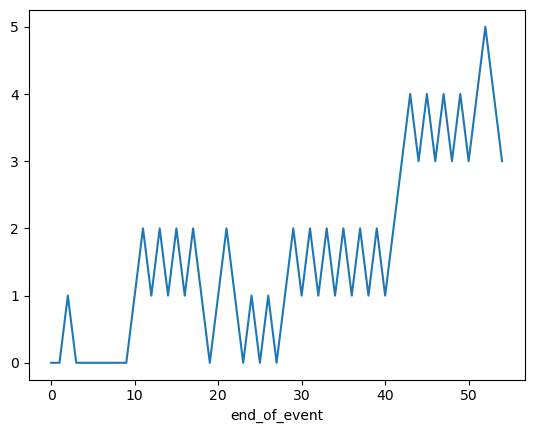

In [487]:
events.waiting_line.plot()